## Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras

Loading the given dataset (Tag3) using the Pandas library. 

In [36]:
import pandas 
dataset = pandas.read_csv('tag3.csv')
dataset

,tag3
0,73.507111
1,73.575470
2,73.841309
3,73.727379
4,73.560287
5,73.757767
6,73.815994
7,73.732445
8,73.760292
9,73.805862


Once loaded, plotting the whole dataset using the code below. 

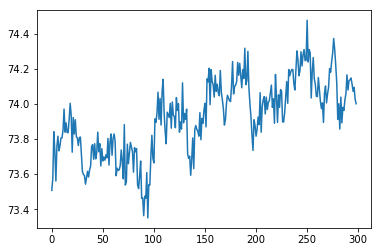

In [37]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('tag3.csv')
plt.plot(dataset)
plt.show()

## Long Short-Term Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

Forget Gate: conditionally decides what information to throw away from the block.
Input Gate: conditionally decides which values from the input to update the memory state.
Output Gate: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

## LSTM Network for forecasting

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing the actual values and the second column containing the predicted values.

Before we get started, let’s first import all of the functions and classes we intend to use. 

In [38]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible.

In [39]:
# fix random seed for reproducibility
numpy.random.seed(7)

Convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [40]:
# load the dataset
dataframe = pandas.read_csv('tag3.csv')
dataset = dataframe.values
dataset = dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [41]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [42]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

200 99


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the tag at a given time (t) and Y is the number tag at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [43]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Let’s use this function to prepare the train and test datasets for modeling.

In [44]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [45]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [46]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
3s - loss: 0.1032
Epoch 2/100
1s - loss: 0.0245
Epoch 3/100
1s - loss: 0.0179
Epoch 4/100
1s - loss: 0.0165
Epoch 5/100
1s - loss: 0.0153
Epoch 6/100
1s - loss: 0.0141
Epoch 7/100
1s - loss: 0.0131
Epoch 8/100
1s - loss: 0.0120
Epoch 9/100
1s - loss: 0.0117
Epoch 10/100
1s - loss: 0.0109
Epoch 11/100
1s - loss: 0.0104
Epoch 12/100
1s - loss: 0.0103
Epoch 13/100
1s - loss: 0.0100
Epoch 14/100
1s - loss: 0.0098
Epoch 15/100
1s - loss: 0.0098
Epoch 16/100
1s - loss: 0.0097
Epoch 17/100
1s - loss: 0.0095
Epoch 18/100
1s - loss: 0.0096
Epoch 19/100
1s - loss: 0.0096
Epoch 20/100
1s - loss: 0.0096
Epoch 21/100
1s - loss: 0.0095
Epoch 22/100
1s - loss: 0.0097
Epoch 23/100
1s - loss: 0.0096
Epoch 24/100
1s - loss: 0.0095
Epoch 25/100
1s - loss: 0.0095
Epoch 26/100
1s - loss: 0.0096
Epoch 27/100
1s - loss: 0.0096
Epoch 28/100
1s - loss: 0.0095
Epoch 29/100
1s - loss: 0.0096
Epoch 30/100
1s - loss: 0.0096
Epoch 31/100
1s - loss: 0.0096
Epoch 32/100
1s - loss: 0.0095
Epoch 33/100
1s -

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data.

In [47]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.11 RMSE
Test Score: 0.11 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in orange, and the predictions on the unseen test dataset in green.

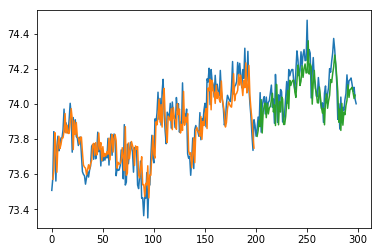

In [48]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [59]:
trainPredict

array([[ 73.57113647],
       [ 73.62200165],
       [ 73.83615112],
       [ 73.74192047],
       [ 73.61051178],
       [ 73.76678467],
       [ 73.81499481],
       [ 73.74604797],
       [ 73.76885986],
       [ 73.80657196],
       [ 73.80657196],
       [ 73.84464264],
       [ 73.94501495],
       [ 73.83403015],
       [ 73.87869263],
       [ 73.83190918],
       [ 73.83190918],
       [ 73.89578247],
       [ 73.9728775 ],
       [ 73.91503906],
       [ 73.73986053],
       [ 73.90433502],
       [ 73.82556915],
       [ 73.89364624],
       [ 73.8128891 ],
       [ 73.80657196],
       [ 73.77095032],
       [ 73.80867004],
       [ 73.81078339],
       [ 73.72547913],
       [ 73.65116882],
       [ 73.63942719],
       [ 73.6335907 ],
       [ 73.597229  ],
       [ 73.62584686],
       [ 73.65313721],
       [ 73.62778473],
       [ 73.65905762],
       [ 73.67692566],
       [ 73.76678467],
       [ 73.77510834],
       [ 73.70713806],
       [ 73.77929688],
       [ 73

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'